<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание: генеративно-состязательные сети</center></h2>

In [125]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [126]:
# read data
names = np.array(['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans', 'Alpha', 'Dist', 'class'])
data = pd.read_csv("magic04.data", header=None)
data.columns = names
data.head()

,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научится генерировать параметры кластеров на изображениях телекопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [127]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == 'h'] = 0

In [128]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [129]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распделения значений каждого параметра для каждого типа частиц.

In [130]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(4*4, 4*2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i+1)
        plt.hist(X1[:, i], bins=bins, alpha=0.5, label=label1, color='C0')
        plt.hist(X2[:, i], bins=bins, alpha=0.5, label=label2, color='C1')
        plt.xlabel(names[i], size=14)
        plt.legend(loc='best')
    plt.tight_layout()

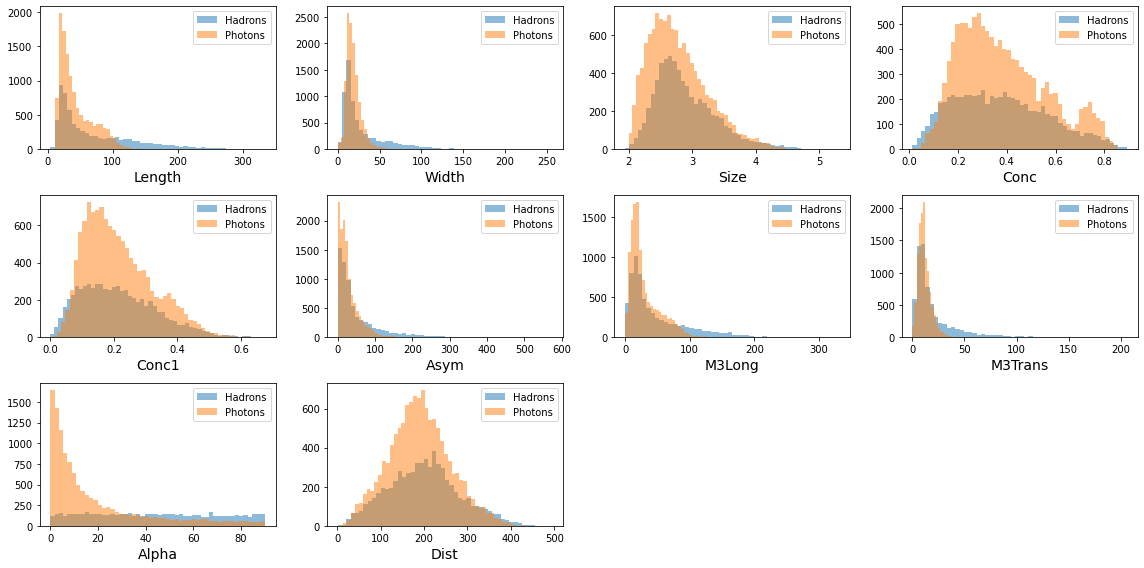

In [131]:
plot_hists(X[y[:, 0]==0], X[y[:, 0]==1], names, label1="Hadrons", label2="Photons", bins=50)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому, нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты. 

Используя функцию `QuantileTransformer` трансформируtv входные данные `X`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным.

In [132]:
from sklearn.preprocessing import QuantileTransformer
X_qt = QuantileTransformer(n_quantiles=1000,output_distribution='normal')
X_qt = X_qt.fit_transform(X)

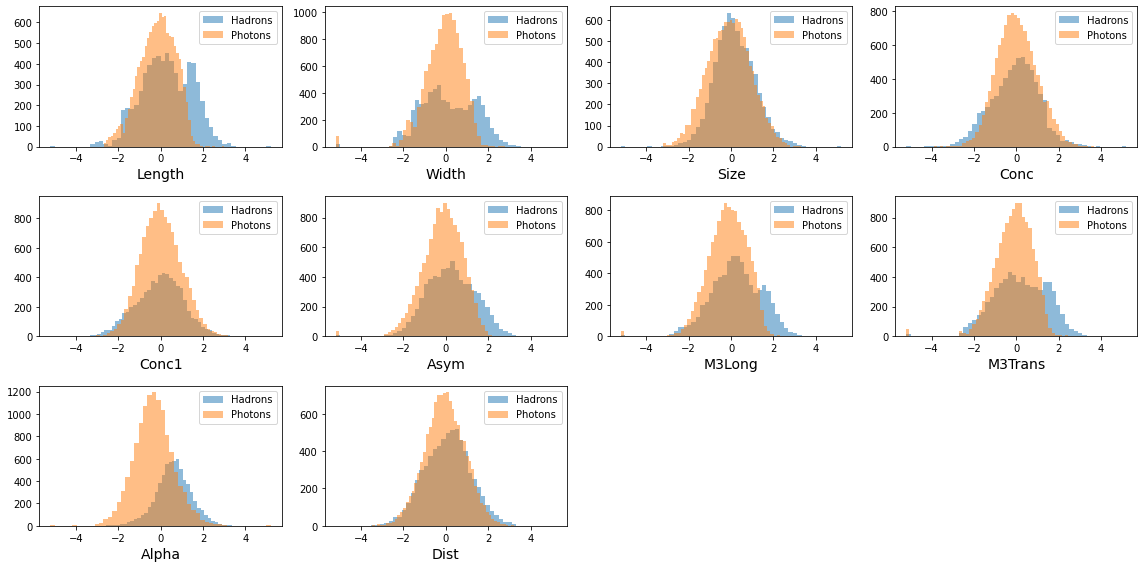

In [133]:
plot_hists(X_qt[y[:, 0]==0], X_qt[y[:, 0]==1], names, label1="Hadrons", label2="Photons", bins=50)

# Обучающая и тестовая выборки

In [134]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X_qt, y, stratify=y, test_size=0.5, shuffle=True, random_state=11)

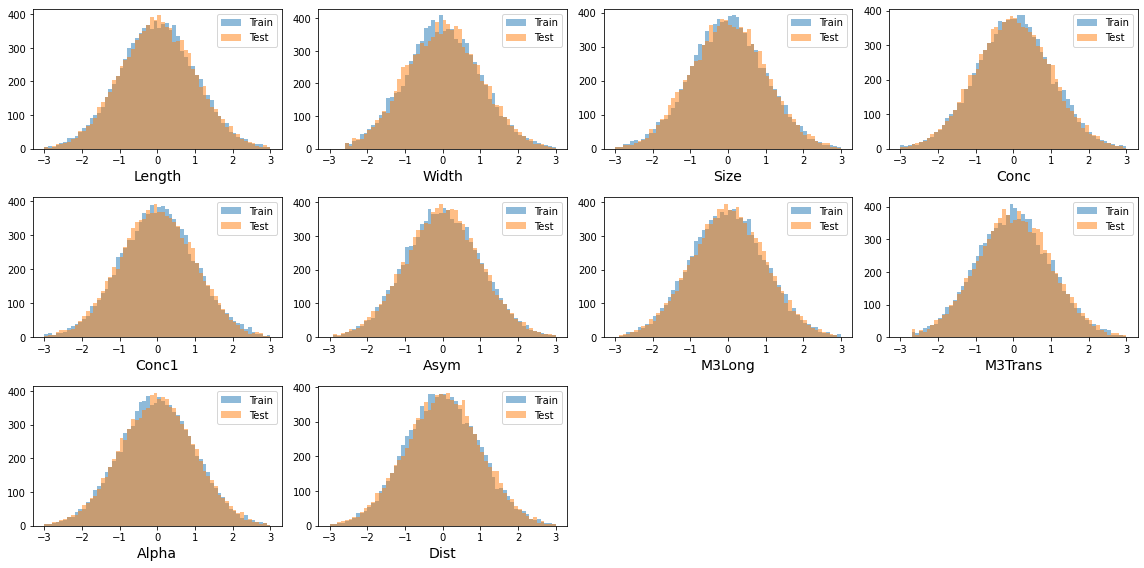

In [135]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/cgan.png?raw=1" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [136]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [137]:
DEVICE

device(type='cpu')

## Задание

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [138]:
class Generator(nn.Module):
    
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100,n_outputs)
        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

In [139]:
class Discriminator(nn.Module):
    
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
      
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x, y):
        for p in self.parameters():
          p.data.clamp_(-0.01, 0.01) #ограничиваем веса в дискриминаторе, как просят ниже
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

## Задание 

Реализуйте класс для обучения генеративной модели.

In [140]:
from typing_extensions import Literal

class Fitter(object):
    
    def __init__(self, generator, discriminator, batch_size=32, n_epochs=10, latent_dim=1, lr=0.0001, n_critic=5):
        
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        
        self.opt_gen  = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)
        
        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)
    
    def loss_func(self, 
                  real_objects_scores: torch.Tensor,
                  gen_objects_scores: torch.Tensor, 
                  by: Literal['gen', 'disc'] = 'gen') -> torch.Tensor:
             if  by == 'gen':
               return torch.nn.functional.logsigmoid(-gen_objects_scores).mean()  #минимизируем лосс для G
             elif by == 'disc':
               return - torch.nn.functional.logsigmoid(real_objects_scores).mean() - torch.nn.functional.logsigmoid( - gen_objects_scores).mean() #минимизируем лосс для D по заданной функции потерь                                                                                                             

    def fit(self, X, y):
        
        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        
        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)
        
        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
          print(f'Epoch {epoch + 1}')
          for i, (real_batch, cond_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):
            
            # генерация объектов
            num_objects = real_batch.shape[0]
            inp = torch.normal(torch.zeros((num_objects, self.latent_dim)), torch.ones((num_objects, self.latent_dim))) 
            gen_objects = self.generator(inp, cond_batch)

            # подсчет скоров
            real_objects_scores, gen_objects_scores = torch.split(self.discriminator(
                torch.cat([real_batch, gen_objects], dim=0), 
                torch.cat([cond_batch, cond_batch], dim=0)), num_objects)

            if (i % (self.n_critic + 1)) == 0:  #каждые 5 шагов дискриминатора шагаем генератор
              # шагаем обучение генератора
              self.opt_gen.zero_grad()
              gen_loss = self.loss_func(real_objects_scores, gen_objects_scores, 'gen')
              gen_loss.backward()
              self.opt_gen.step()

            else:
              # шагаем обучение дискриминатора
              self.opt_disc.zero_grad()
              discr_loss = self.loss_func(real_objects_scores, gen_objects_scores, 'disc')
              discr_loss.backward()
              self.opt_disc.step()

            # calculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(self.discriminator(X_fake, y_cond))
            self.loss_history.append(loss_epoch.detach().cpu())
                    
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [141]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim+y.shape[1], 
                          n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1]+y.shape[1])

fitter = Fitter(generator, discriminator, batch_size=50, n_epochs=100, latent_dim=latent_dim, lr=0.0001, n_critic=5)
fitter.fit(X_train, y_train)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
CPU times: user 10min 39s, sys: 24.6 s, total: 11min 3s
Wall time: 11min 11s


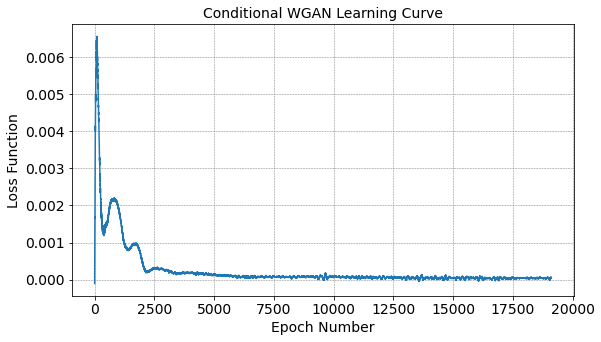

In [142]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

## Задание 

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [143]:
def generate(generator, y, latent_dim):
    
    inp = torch.normal(torch.zeros((y.shape[0], latent_dim)), torch.ones((y.shape[0], latent_dim)))  
    X_fake = generator(inp, torch.tensor(y, dtype = torch.float))
    
    return X_fake.detach().numpy()

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`

In [144]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)

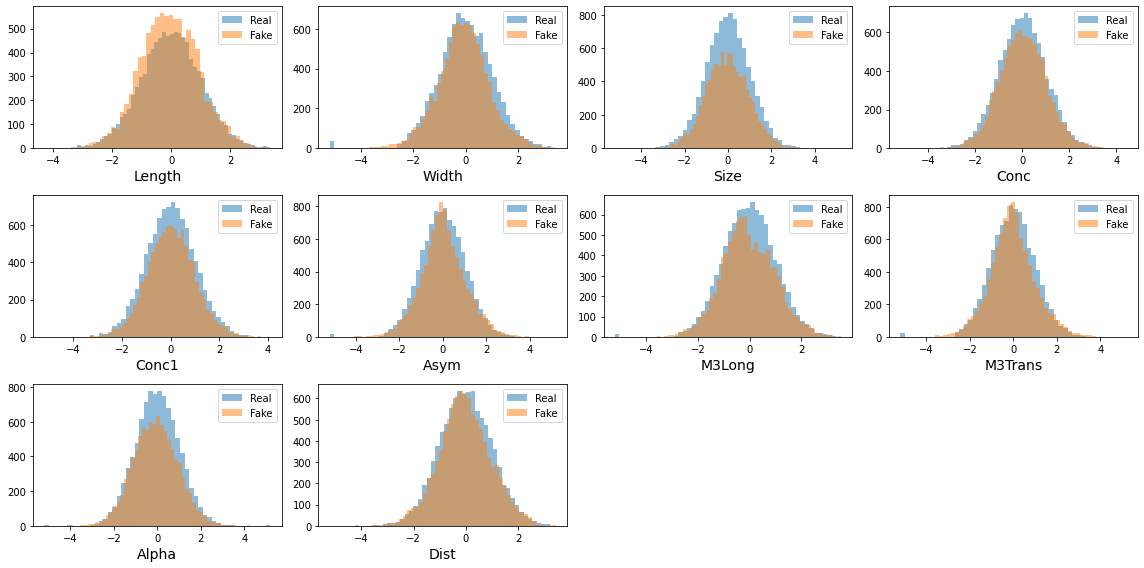

In [145]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [146]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)

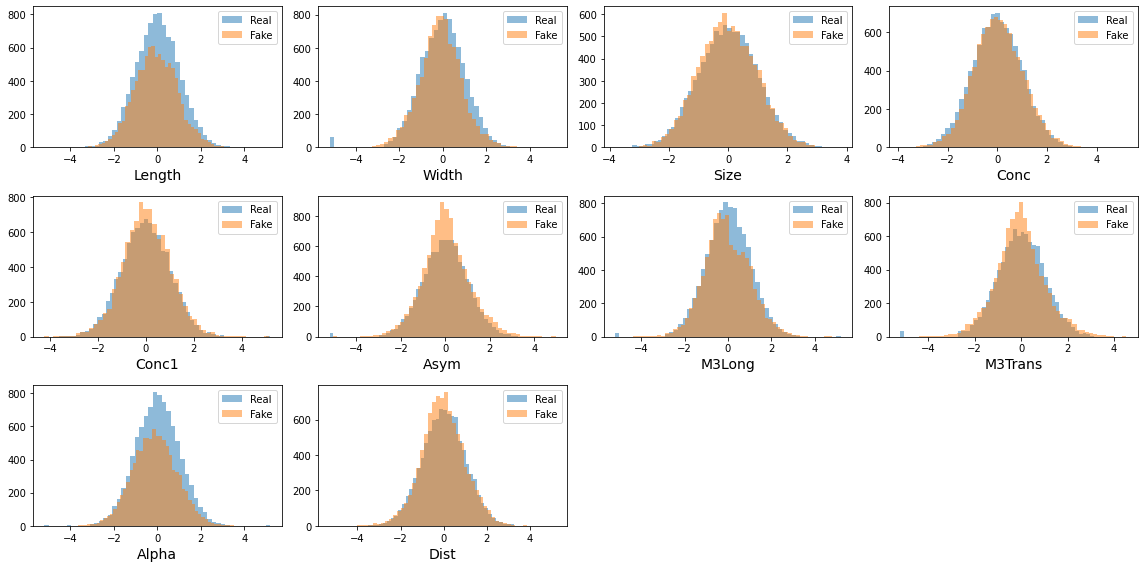

In [147]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод 1: 
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации


Измерим сходство распределений классификатором.

In [148]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0]*len(X_fake_train) + [1]*len(X_train))
yy_test = np.array([0]*len(X_fake_test) + [1]*len(X_test))

In [149]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [150]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7147523885975358


## Вывод 2

Идеальное значение ROC AUC равно 0.5. Это соответствует случаю, когда классификатор не может разделить реальные и фейковые данные. В нашем случае ROC AUC около 0.7, что говорит о том, что есть куда улучшать качество генеративной модели :)

# Условные вариационные автокодировщики

Теперь, решим эту же задачу используя условный автокодировщик (CVAE)

## Задание 6 

Реализуйте нейронную сеть для декодеровщика со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой для mu; Выходной слой для log_sigma;


In [151]:
class Encoder(nn.Module):
    def __init__(self, n_inputs, lat_size):
        super(Encoder, self).__init__()
        
        ### YOUR CODE IS HERE ######
        self.lat_size = lat_size
        self.enc_net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100), 
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100), 
            nn.ReLU(),
        )
        
        self.mu = nn.Linear(100, self.lat_size)
        self.log_sigma = nn.Linear(100, self.lat_size)
        ### THE END OF YOUR CODE ###
        
    def forward(self, x, y):
        z = torch.cat((x, y), dim=1)
        z = self.enc_net(z)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        return mu, log_sigma 

## Задание 7

Реализуйте нейронную сеть для декодеровщика со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

In [152]:
class Decoder(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Decoder, self).__init__()
       
        self.dec_net = nn.Sequential(
            nn.Linear(n_inputs,100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )
      
        
    def forward(self, z, y):
        z_cond = torch.cat((z, y), dim=1)
        x_rec = self.dec_net(z_cond)
        return x_rec

## Задание 8

Реализуйте класс для обучения вариационного автокодировщика.

In [153]:
class VAEFitter(object):
    
    def __init__(self, encoder, decoder, batch_size=32, n_epochs=10, latent_dim=1, lr=0.0001, KL_weight=0.001):
        
        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.KL_weight = KL_weight
        
        self.criterion = nn.MSELoss()
        self.opt  = torch.optim.RMSprop(list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=self.lr)
        
        self.encoder.to(DEVICE)
        self.decoder.to(DEVICE)
        
        
    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(DEVICE)
        return mu + torch.exp(log_sigma / 2) * eps
    
    def custom_loss(self, x, rec_x, mu, log_sigma):
        KL = torch.mean(-0.5 * torch.sum(1 + log_sigma - mu ** 2 - log_sigma.exp(), dim = 1), dim = 0)
        recon_loss = self.criterion(x, rec_x)
        return KL*self.KL_weight + recon_loss
    
    
    def compute_loss(self, x_batch, cond_batch):
        
        mu, log_sigma = self.encoder(x_batch, cond_batch)
        z = self.sample_z(mu, log_sigma)
        rec_x = self.decoder(z, cond_batch)
        
        loss = self.custom_loss(x_batch, rec_x, mu, log_sigma)

        return loss
    
    
    def fit(self, X, y):
        
        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        
        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)
        
        # Turn on training
        self.encoder.train(True)
        self.decoder.train(True)
        
        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (x_batch, cond_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):
                
                # caiculate loss
                loss = self.compute_loss(x_batch, cond_batch)
                
                # optimization step
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
                    
            # caiculate and store loss after an epoch
            loss_epoch = self.compute_loss(X_real, y_cond)
            self.loss_history.append(loss_epoch.detach().cpu())
                    
        # Turn off training
        self.encoder.train(False)
        self.decoder.train(False)

## Обучение
Обучим модель на данных.

In [154]:
%%time

latent_dim = 10

encoder = Encoder(n_inputs=X_train.shape[1]+y.shape[1], lat_size=latent_dim)
decoder = Decoder(n_inputs=latent_dim+y.shape[1], n_outputs=X_train.shape[1])

vae_fitter = VAEFitter(encoder, decoder, batch_size=50, n_epochs=100, latent_dim=latent_dim, lr=0.001, KL_weight=0.001)
vae_fitter.fit(X_train, y_train)

CPU times: user 48.9 s, sys: 218 ms, total: 49.1 s
Wall time: 49.1 s


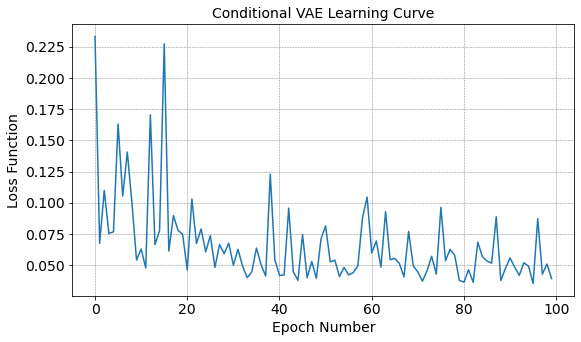

In [155]:
# CVAE learning curve
plt.figure(figsize=(9, 5))
plt.plot(vae_fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional VAE Learning Curve", size=14)
plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

## Задание 9 

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [156]:
def generate(decoder, y, latent_dim):
    
    inp = torch.normal(torch.zeros((y.shape[0], latent_dim)), torch.ones((y.shape[0], latent_dim)))  
    X_fake = generator(inp, torch.tensor(y, dtype = torch.float))

    return X_fake.detach().numpy() # чтобы график нарисовался

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`

In [157]:
X_fake_train = generate(vae_fitter.decoder, y_train, latent_dim)

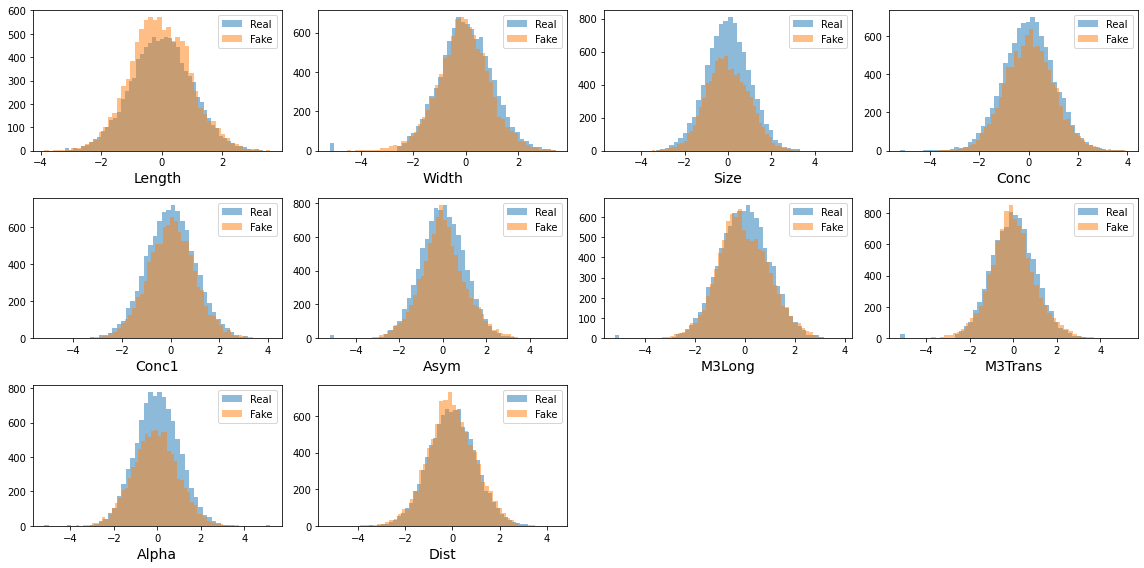

In [158]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [159]:
X_fake_test = generate(vae_fitter.decoder, y_test, latent_dim)

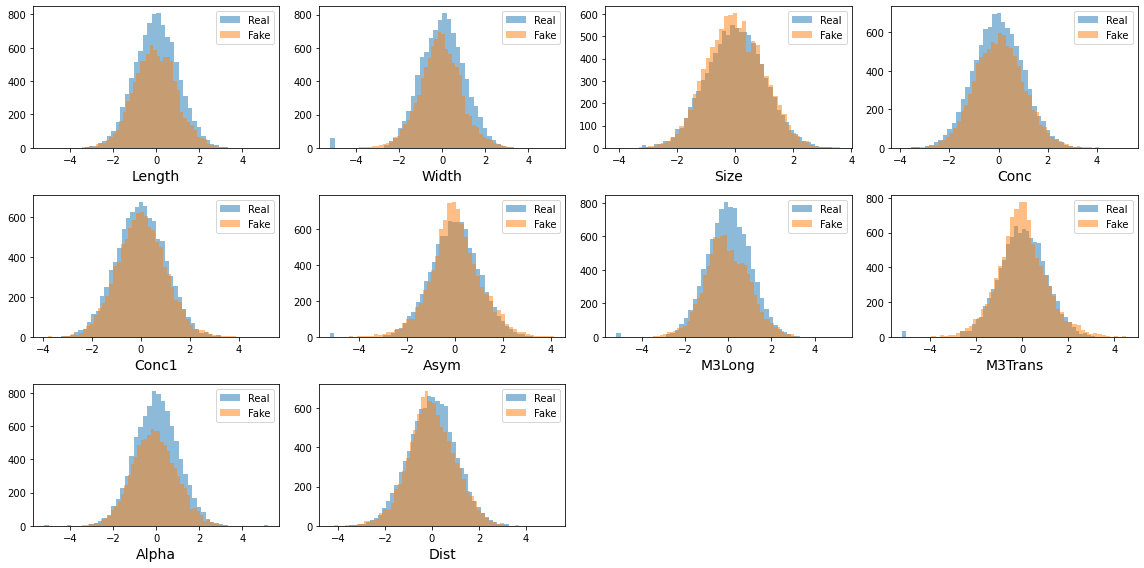

In [160]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

# Измерение качества генерации

Измерим сходство распределений классификатором.

In [161]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0]*len(X_fake_train) + [1]*len(X_train))
yy_test = np.array([0]*len(X_fake_test) + [1]*len(X_test))

In [162]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [163]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7198352500715944


## Вывод 3

Для CVAE получили ROC AUC около 0.7 (меньше лучше). Таким образом видим, что в данной задаче обе модели ведут себя схожим образом.